In [1]:
import os
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conf = pyspark.SparkConf()

conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','8g')
sc = pyspark.SparkContext(conf=conf)

spark = pyspark.SQLContext.getOrCreate(sc)
from pyspark.sql.functions import *

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/06 20:42:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
df = spark\
.read\
.option("inferSchema","true")\
.option("header", "true")\
.csv("ratings.csv")

In [4]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [5]:
df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows



In [6]:
#Split the data into train and test set
train, test = df.randomSplit([0.8,0.2])

### Examining our Data

In [8]:
#GroupBy movie ratings to check for the number of users
user_count = train.groupBy('userId').count().toPandas()

Max User Count: 18925
Min User Count: 1


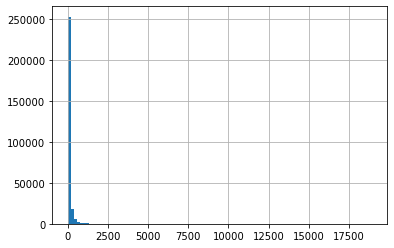

In [7]:
print('Max User Count: {}'.format(user_count['count'].max()))
print('Min User Count: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Movie Count: 78058
Min Movie Count: 1


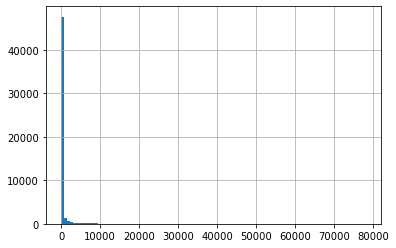

In [8]:
#GroupBy user ratings each movie has
movie_count = train.groupBy('movieId').count().toPandas()
print('Max Movie Count: {}'.format(movie_count['count'].max()))
print('Min Movie Count: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

### Training our Model

In [7]:
#Training the ALS model
from pyspark.ml.recommendation import ALS

als_model = ALS(userCol='userId',
                itemCol='movieId',
                nonnegative=True,
                regParam=0.1,
                rank=10)
# rank is the number of latent factors we are choosing

recommender = als_model.fit(train)

In [8]:
predictions = recommender.transform(test)

In [7]:
predictions.describe().show()

+-------+------------------+------------------+------------------+--------------------+----------+
|summary|            userId|           movieId|            rating|           timestamp|prediction|
+-------+------------------+------------------+------------------+--------------------+----------+
|  count|           5534620|           5534620|           5534620|             5534620|   5534620|
|   mean|141693.27861063633|18490.593925147525| 3.530806902732256|1.1930416301581771E9|       NaN|
| stddev| 81532.85424541403|35121.241928582065|1.0659419912127408| 2.160565057405978E8|       NaN|
|    min|                 1|                 1|               0.5|           789652004|       0.0|
|    max|            282472|            193886|               5.0|          1537945149|       NaN|
+-------+------------------+------------------+------------------+--------------------+----------+



In [9]:
predictions.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [13]:
#drop Null values
predictions = predictions.na.drop()

userId,movieId,rating,timestamp,prediction
1,3424,4.5,1256677444,3.956502
1,3698,3.5,1256677243,3.0745933
3,828,4.0,945141610,2.7038386
3,1825,3.0,945141611,2.481729
3,2024,3.0,945141611,2.9851801
3,3171,4.0,945141407,3.2918122
5,296,5.0,1209040010,4.595757
5,318,5.0,1209040104,4.614525
5,527,4.5,1209126022,4.3504653
5,858,4.5,1209125953,4.523577


### Calculating Error

In [14]:
predictions = predictions.withColumn("squared_error", (predictions.rating - predictions.prediction)**2)

In [15]:
predictions.show(5)

+------+-------+------+----------+----------+--------------------+
|userId|movieId|rating| timestamp|prediction|       squared_error|
+------+-------+------+----------+----------+--------------------+
|     1|   3424|   4.5|1256677444|  3.956502|  0.2953901186638177|
|     1|   3698|   3.5|1256677243| 3.0745933| 0.18097085565074167|
|     3|    828|   4.0| 945141610| 2.7038386|  1.6800344090498243|
|     3|   1825|   3.0| 945141611|  2.481729|  0.2686047977133512|
|     3|   2024|   3.0| 945141611| 2.9851801|2.196282640056779...|
+------+-------+------+----------+----------+--------------------+
only showing top 5 rows



In [16]:
import pyspark.sql.functions as F
rmse = predictions.select(F.sqrt(F.avg(F.col('squared_error'))).alias('rmse'))

In [17]:
rmse

rmse
0.8245183929918704


In [18]:
predictions_df = predictions.toPandas()

### Violin Plot

/opt/conda/envs/bigdata/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/opt/conda/envs/bigdata/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


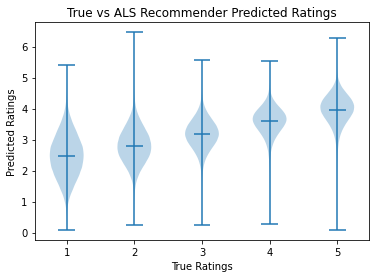

In [19]:
#Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1,6)]
plt.violinplot(data,range(1,6),showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs ALS Recommender Predicted Ratings')
plt.show()

### Movie and User Recommendation

In [20]:
#Generate top 10 movie recommendations for each user
userRecs = recommender.recommendForAllUsers(10)
#Generate top 10 user recommendations for each movie
movieRecs = recommender.recommendForAllItems(10)
userRecs_df = userRecs.toPandas()
movieRecs_df = movieRecs.toPandas()

/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [21]:
def get_movie_recommendations(user_id):
    return userRecs_df.loc[user_id].recommendations

In [22]:
get_movie_recommendations(1)

[Row(movieId=151989, rating=4.723522186279297),
 Row(movieId=191203, rating=4.654873847961426),
 Row(movieId=177209, rating=4.397883892059326),
 Row(movieId=183947, rating=4.074903964996338),
 Row(movieId=190707, rating=4.041896820068359),
 Row(movieId=184299, rating=3.989130973815918),
 Row(movieId=159761, rating=3.896301746368408),
 Row(movieId=176597, rating=3.8759632110595703),
 Row(movieId=66389, rating=3.8478126525878906),
 Row(movieId=166812, rating=3.825347900390625)]

In [25]:
get_movie_recommendations(420)

[Row(movieId=191203, rating=7.803248882293701),
 Row(movieId=177209, rating=7.1907782554626465),
 Row(movieId=151989, rating=7.178464889526367),
 Row(movieId=159761, rating=6.259659767150879),
 Row(movieId=176597, rating=6.22702693939209),
 Row(movieId=117352, rating=6.147378921508789),
 Row(movieId=183947, rating=6.038647651672363),
 Row(movieId=190707, rating=6.0363054275512695),
 Row(movieId=192261, rating=5.994150638580322),
 Row(movieId=173153, rating=5.9930195808410645)]

In [23]:
def get_user_recommendations(movie_id):
    return movieRecs_df.loc[movie_id].recommendations

In [24]:
get_user_recommendations(1)

[Row(userId=214014, rating=5.033578872680664),
 Row(userId=265979, rating=4.982534885406494),
 Row(userId=96088, rating=4.941077709197998),
 Row(userId=49825, rating=4.921493053436279),
 Row(userId=236476, rating=4.9098052978515625),
 Row(userId=229727, rating=4.902568340301514),
 Row(userId=121527, rating=4.902458667755127),
 Row(userId=104645, rating=4.876795768737793),
 Row(userId=125590, rating=4.874320030212402),
 Row(userId=157646, rating=4.865233421325684)]

In [26]:
get_user_recommendations(420)

[Row(userId=268794, rating=5.477743625640869),
 Row(userId=26541, rating=5.4765543937683105),
 Row(userId=121527, rating=5.319829940795898),
 Row(userId=33746, rating=5.213842868804932),
 Row(userId=10538, rating=5.117254257202148),
 Row(userId=213750, rating=5.115749359130859),
 Row(userId=115750, rating=5.112091541290283),
 Row(userId=91791, rating=5.10179328918457),
 Row(userId=63517, rating=5.092469215393066),
 Row(userId=257250, rating=5.065879821777344)]